# Tutorial 6: Mixed Precision Quantization Search with Mase and Optuna

In this tutorial, we'll see how Mase can be integrated with Optuna, the popular hyperparameter optimization framework, to search for a Bert model optimized for sequence classification on the IMDb dataset. We'll take the Optuna-generated model and import it into Mase, then run the CompressionPipeline to prepare the model for edge deployment by quantizing and pruning its weights.

As we'll see, running Architecture Search with Mase/Optuna involves the following steps.

1. **Define the search space**: this is a dictionary containing the range of values for each parameter at each layer in the model.

2. **Write the model constructor**: this is a function which uses Optuna utilities to sample a model from the search space, and constructs the model using transformers from_config class method.

3. **Write the objective function**: this function calls on the model constructor defined in Step 2 and defines the training/evaluation setup for each search iteration.

4. **Go!** Choose an Optuna sampler, create a study and launch the search.

In [2]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can load the Bert checkpoint directly from HuggingFace.

In [3]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

/vol/bitbucket/ug22/adls/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


If you have previously ran the tutorial on Neural Architecture Search (NAS), run the following cell to import the best model obtained from the search process.

In [3]:
from transformers import AutoModelForSequenceClassification

base_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2  # IMDb is binary classification
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from pathlib import Path
import dill

with open(f"{Path.home()}/tutorial_5_best_model.pkl", "rb") as f:
    base_model = dill.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/homes/ug22/tutorial_5_best_model.pkl'

First, fetch the dataset using the `get_tokenized_dataset` utility.

In [4]:
from chop.tools import get_tokenized_dataset

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


## 1. Defining the Search Space

We'll start by defining a search space, i.e. enumerating the possible combinations of hyperparameters that Optuna can choose during search. We'll explore the following range of values for the model's hidden size, intermediate size, number of layers and number of heads.

In [5]:
import torch
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
    LinearBlockFP,
    LinearBlockMinifloat,
    LinearBlockLog,
    LinearBinary,
    LinearBinaryScaling,
    LinearBinaryResidualSign,
)

search_space = {
    "linear_layer_choices": [
        torch.nn.Linear,
        LinearInteger,
    ],
    "width_choices": [8, 16, 32],
    "frac_width_choices": [2, 4, 8],
}

## 2. Writing a Model Constructor

We define the following function, which will get called in each iteration of the search process. The function is passed the `trial` argument, which is an Optuna object that comes with many functionalities - see the [Trial documentation](https://optuna.readthedocs.io/en/stable/reference/trial.html) for more details. Here, we use the `trial.suggest_categorical` function, which triggers the chosen sampler to choose a layer type. The suggested integer is the index into the search space for each parameter, which we defined in the previous cell.

In [8]:
from chop.tools.utils import deepsetattr
from copy import deepcopy


def construct_model(trial):

    # Fetch the model
    trial_model = deepcopy(base_model)

    # Quantize layers according to optuna suggestions
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            new_layer_cls = trial.suggest_categorical(
                f"{name}_type",
                search_space["linear_layer_choices"],
            )

            if new_layer_cls == torch.nn.Linear:
                continue

            kwargs = {
                "in_features": layer.in_features,
                "out_features": layer.out_features,
            }

            # If the chosen layer is integer, define the low precision config
            # if new_layer_cls == LinearInteger:
            #     kwargs["config"] = {
            #         "data_in_width": 8,
            #         "data_in_frac_width": 4,
            #         "weight_width": 8,
            #         "weight_frac_width": 4,
            #         "bias_width": 8,
            #         "bias_frac_width": 4,
            #     }
            # elif... (other precisions)

            # If the chosen layer is integer, let Optuna pick width/frac_width for THIS layer
            if new_layer_cls == LinearInteger:
                width = trial.suggest_categorical(
                    f"{name}_width", 
                    search_space["width_choices"]
                )
                frac_width = trial.suggest_categorical(
                    f"{name}_frac_width", 
                    search_space["frac_width_choices"]
                )
                
                kwargs["config"] = {
                    "data_in_width": width,
                    "data_in_frac_width": frac_width,
                    "weight_width": width,
                    "weight_frac_width": frac_width,
                    "bias_width": width,
                    "bias_frac_width": frac_width,
                }

            # Create the new layer (copy the weights)
            new_layer = new_layer_cls(**kwargs)
            new_layer.weight.data = layer.weight.data

            # Replace the layer in the model
            deepsetattr(trial_model, name, new_layer)

    return trial_model

## 3. Defining the Objective Function

Next, we define the objective function for the search, which gets called on each trial. In each trial, we create a new model instace with chosen hyperparameters according to the defined sampler. We then use the `get_trainer` utility in Mase to run a training loop on the IMDb dataset for a number of epochs. Finally, we use `evaluate` to report back the classification accuracy on the test split.

In [9]:
from chop.tools import get_trainer
import random


def objective(trial):

    # Define the model
    model = construct_model(trial)

    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    trial.set_user_attr("model", model)

    return eval_results["eval_accuracy"]

## 4. Launching the Search

Optuna provides a number of samplers, for example:

* **GridSampler**: iterates through every possible combination of hyperparameters in the search space
* **RandomSampler**: chooses a random combination of hyperparameters in each iteration
* **TPESampler**: uses Tree-structured Parzen Estimator algorithm to choose hyperparameter values.

You can define the chosen sampler by simply importing from `optuna.samplers` as below.

In [10]:
from optuna.samplers import GridSampler, RandomSampler, TPESampler

sampler = TPESampler()

With all the pieces in place, we can launch the search as follows. The number of trials is set to 1 so you can go get a coffee for 10 minutes, then proceed with the tutorial. However, this will essentially be a random model - for better results, set this to 100 and leave it running overnight!

In [12]:
# import optuna

# study = optuna.create_study(
#     direction="maximize",
#     study_name="bert-tiny-nas-study",
#     sampler=sampler,
# )

# study.optimize(
#     objective,
#     n_trials=1,
#     timeout=60 * 60 * 24,
# )

import optuna

print(search_space)

study = optuna.create_study(
    direction="maximize",
    study_name="bert-tiny-mixed-precision-study",
    sampler=sampler,
)

study.optimize(
    objective,
    n_trials=20,
    timeout=60 * 60 * 24,
)

[I 2026-02-02 16:51:25,760] A new study created in memory with name: bert-tiny-mixed-precision-study


{'linear_layer_choices': [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.quantized.modules.linear.LinearInteger'>], 'width_choices': [8, 16, 32], 'frac_width_choices': [2, 4, 8]}


/vol/bitbucket/ug22/adls/.venv/lib/python3.11/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.linear.Linear'> which is of type type.
  warnings.warn(message)
/vol/bitbucket/ug22/adls/.venv/lib/python3.11/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'chop.nn.quantized.modules.linear.LinearInteger'> which is of type type.
  warnings.warn(message)
/vol/bitbucket/ug22/adls/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.630800
1000,0.473800
1500,0.429000
2000,0.382700
2500,0.366700
3000,0.375300


[I 2026-02-02 16:52:15,435] Trial 0 finished with value: 0.84796 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_frac_width': 8, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modu

Step,Training Loss
500,0.627400
1000,0.464400
1500,0.416300
2000,0.383900
2500,0.360500
3000,0.372700


[I 2026-02-02 16:53:00,231] Trial 1 finished with value: 0.85688 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attent

Step,Training Loss
500,0.661300
1000,0.545800
1500,0.471600
2000,0.423000
2500,0.399000
3000,0.395600


[I 2026-02-02 16:53:55,149] Trial 2 finished with value: 0.84528 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_frac_width': 4, 'bert.encoder.layer.0.intermedi

Step,Training Loss
500,0.635700
1000,0.452700
1500,0.407200
2000,0.381600
2500,0.364300
3000,0.374900


[I 2026-02-02 16:54:41,781] Trial 3 finished with value: 0.85852 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.en

Step,Training Loss
500,0.601200
1000,0.430500
1500,0.398900
2000,0.371200
2500,0.361500
3000,0.365400


[I 2026-02-02 16:55:25,265] Trial 4 finished with value: 0.86148 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-02 16:56:20,474] Trial 5 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 8, 'bert.encoder.layer.0.intermediate

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-02 16:57:07,132] Trial 6 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.output.dense_width': 32, 'bert.encoder.layer.0.output.dense_frac_width': 2, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 4, 'bert.encoder.layer.1.attention.self.key_typ

Step,Training Loss
500,0.663800
1000,0.494100
1500,0.442300
2000,0.402500
2500,0.382900
3000,0.394700


[I 2026-02-02 16:57:58,080] Trial 7 finished with value: 0.84768 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermedi

Step,Training Loss
500,0.620200
1000,0.460400
1500,0.418400
2000,0.381700
2500,0.355400
3000,0.364400


[I 2026-02-02 16:58:46,092] Trial 8 finished with value: 0.85224 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 4, 'bert.encoder.layer.0.output.dense_type': <class 'chop.nn.quantized.modules.line

Step,Training Loss
500,0.623600
1000,0.466800
1500,0.415800
2000,0.383000
2500,0.360600
3000,0.360700


[I 2026-02-02 16:59:30,964] Trial 9 finished with value: 0.8582 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_frac_width': 4, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.enc

Step,Training Loss
500,0.611000
1000,0.423900
1500,0.401100
2000,0.369200
2500,0.357600
3000,0.365100


[I 2026-02-02 17:00:18,063] Trial 10 finished with value: 0.85988 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_width': 8, 

Step,Training Loss
500,0.611000
1000,0.423900
1500,0.401100
2000,0.369200
2500,0.357600
3000,0.365100


[I 2026-02-02 17:01:04,895] Trial 11 finished with value: 0.85988 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_width': 8, 

Step,Training Loss
500,0.610500
1000,0.423100
1500,0.404400
2000,0.371200
2500,0.359300
3000,0.363300


[I 2026-02-02 17:01:51,802] Trial 12 finished with value: 0.85928 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_width': 8, 

Step,Training Loss
500,0.604900
1000,0.430600
1500,0.405000
2000,0.369300
2500,0.362100
3000,0.371800


[I 2026-02-02 17:02:38,446] Trial 13 finished with value: 0.85852 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.key_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.key_width': 8,

Step,Training Loss
500,0.600300
1000,0.431100
1500,0.404200
2000,0.371700
2500,0.363500
3000,0.364200


[I 2026-02-02 17:03:22,831] Trial 14 finished with value: 0.86076 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch

Step,Training Loss
500,0.600300
1000,0.431100
1500,0.404200
2000,0.371700
2500,0.363500
3000,0.364200


[I 2026-02-02 17:04:06,538] Trial 15 finished with value: 0.86076 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch

Step,Training Loss
500,0.600600
1000,0.433700
1500,0.406300
2000,0.376100
2500,0.367500
3000,0.363900


[I 2026-02-02 17:04:49,048] Trial 16 finished with value: 0.85832 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch

Step,Training Loss
500,0.597900
1000,0.428800
1500,0.402900
2000,0.375300
2500,0.363200
3000,0.358700


[I 2026-02-02 17:05:32,815] Trial 17 finished with value: 0.8604 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.

Step,Training Loss
500,0.638000
1000,0.476600
1500,0.426200
2000,0.388800
2500,0.377300
3000,0.385400


[I 2026-02-02 17:06:19,934] Trial 18 finished with value: 0.8546 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch.n

Step,Training Loss
500,0.609600
1000,0.434400
1500,0.402900
2000,0.368900
2500,0.359300
3000,0.359100


[I 2026-02-02 17:07:03,807] Trial 19 finished with value: 0.85876 and parameters: {'bert.encoder.layer.0.attention.self.query_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.self.value_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.attention.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.intermediate.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.0.output.dense_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.query_type': <class 'chop.nn.quantized.modules.linear.LinearInteger'>, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_type': <class 'torch.nn.modules.linear.Linear'>, 'bert.encoder.layer.1.attention.self.value_type': <class 'torch

In [13]:
print(search_space)

{'linear_layer_choices': [<class 'torch.nn.modules.linear.Linear'>, <class 'chop.nn.quantized.modules.linear.LinearInteger'>], 'width_choices': [8, 16, 32], 'frac_width_choices': [2, 4, 8]}


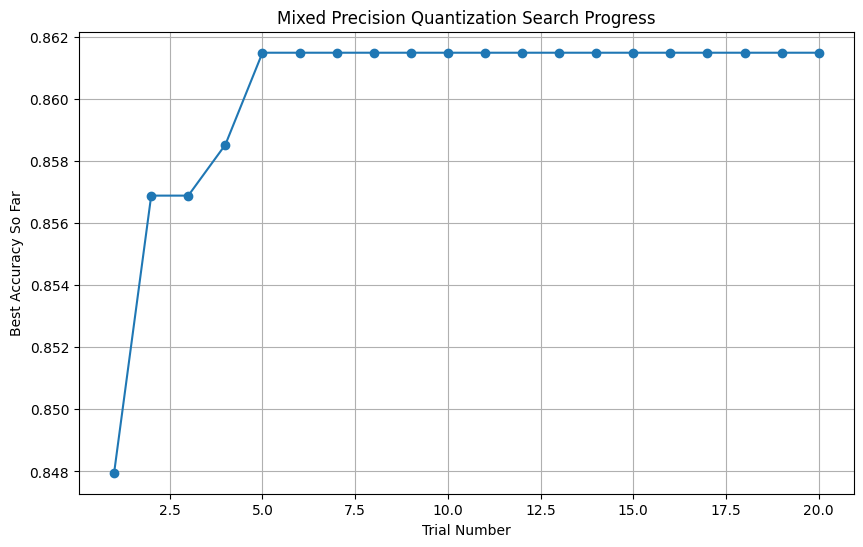

In [14]:
import matplotlib.pyplot as plt

# Extract accuracy from each trial in order
trial_accuracies = [trial.value for trial in study.trials]

# Compute best accuracy up to each trial
best_so_far = []
current_best = 0
for acc in trial_accuracies:
    if acc is not None and acc > current_best:
        current_best = acc
    best_so_far.append(current_best)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_so_far) + 1), best_so_far, marker='o')
plt.xlabel("Trial Number")
plt.ylabel("Best Accuracy So Far")
plt.title("Mixed Precision Quantization Search Progress")
plt.grid(True)
plt.savefig("task1_search_progress.png", dpi=150)
plt.show()

In [16]:
# Best trial overall
best_trial = study.best_trial

print(f"Best accuracy: {best_trial.value}")
print(f"Best trial number: {best_trial.number}")
print(f"\nBest parameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best accuracy: 0.86148
Best trial number: 4

Best parameters:
  bert.encoder.layer.0.attention.self.query_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.attention.self.key_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.attention.self.value_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.attention.output.dense_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.intermediate.dense_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.output.dense_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.1.attention.self.query_type: <class 'chop.nn.quantized.modules.linear.LinearInteger'>
  bert.encoder.layer.1.attention.self.query_width: 32
  bert.encoder.layer.1.attention.self.query_frac_width: 2
  bert.encoder.layer.1.attention.self.key_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.1.attention.self.value_type: <class 'torch.nn.modules.linear.Linear'>
  b

In [17]:
# Summary of all trials
import pandas as pd

trials_data = []
for trial in study.trials:
    trial_info = {
        "trial": trial.number,
        "accuracy": trial.value,
    }
    # Count how many layers were quantized vs kept as Linear
    n_quantized = sum(1 for k, v in trial.params.items() if "_type" in k and "LinearInteger" in str(v))
    n_linear = sum(1 for k, v in trial.params.items() if "_type" in k and v == torch.nn.Linear)
    trial_info["n_quantized"] = n_quantized
    trial_info["n_full_precision"] = n_linear
    trials_data.append(trial_info)

df = pd.DataFrame(trials_data)
print(df.sort_values("accuracy", ascending=False))

    trial  accuracy  n_quantized  n_full_precision
4       4   0.86148            2                12
15     15   0.86076            3                11
14     14   0.86076            3                11
17     17   0.86040            3                11
10     10   0.85988            5                 9
11     11   0.85988            5                 9
12     12   0.85928            5                 9
19     19   0.85876            3                11
13     13   0.85852            5                 9
3       3   0.85852            5                 9
16     16   0.85832            2                12
9       9   0.85820            4                10
1       1   0.85688            4                10
18     18   0.85460            5                 9
8       8   0.85224            6                 8
0       0   0.84796            7                 7
7       7   0.84768            8                 6
2       2   0.84528           11                 3
5       5   0.50000            

In [18]:
# Best trial overall
best_trial = study.best_trial

print(f"Best accuracy: {best_trial.value}")
print(f"Best trial number: {best_trial.number}")
print(f"\nBest parameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best accuracy: 0.86148
Best trial number: 4

Best parameters:
  bert.encoder.layer.0.attention.self.query_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.attention.self.key_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.attention.self.value_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.attention.output.dense_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.intermediate.dense_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.0.output.dense_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.1.attention.self.query_type: <class 'chop.nn.quantized.modules.linear.LinearInteger'>
  bert.encoder.layer.1.attention.self.query_width: 32
  bert.encoder.layer.1.attention.self.query_frac_width: 2
  bert.encoder.layer.1.attention.self.key_type: <class 'torch.nn.modules.linear.Linear'>
  bert.encoder.layer.1.attention.self.value_type: <class 'torch.nn.modules.linear.Linear'>
  b

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
)
from chop.tools.utils import deepsetattr
from chop.tools import get_trainer
from copy import deepcopy
from optuna.samplers import TPESampler
import optuna
import matplotlib.pyplot as plt
import json
import pickle
from datetime import datetime
from pathlib import Path

N_TRIALS = 50
OUTPUT_DIR = Path("task2_results")
OUTPUT_DIR.mkdir(exist_ok=True)

LAYER_TYPES = {
    "Linear": torch.nn.Linear,
    "Integer": LinearInteger,
    "MinifloatDenorm": LinearMinifloatDenorm,
    "MinifloatIEEE": LinearMinifloatIEEE,
    "Log": LinearLog,
}

WIDTH_CHOICES = [8, 16, 32]
FRAC_WIDTH_CHOICES = [2, 4, 8]
EXPONENT_WIDTH_CHOICES = [2, 4, 8]
EXPONENT_BIAS_CHOICES = [3, 7, 15]

def build_config(trial, layer_name, precision_type):
    if precision_type == "Linear":
        return None
    
    elif precision_type == "Integer":
        width = trial.suggest_categorical(f"{layer_name}_width", WIDTH_CHOICES)
        frac_width = trial.suggest_categorical(f"{layer_name}_frac_width", FRAC_WIDTH_CHOICES)
        return {
            "data_in_width": width, "data_in_frac_width": frac_width,
            "weight_width": width, "weight_frac_width": frac_width,
            "bias_width": width, "bias_frac_width": frac_width,
        }
    
    elif precision_type in ["MinifloatDenorm", "MinifloatIEEE"]:
        width = trial.suggest_categorical(f"{layer_name}_width", WIDTH_CHOICES)
        exp_width = trial.suggest_categorical(f"{layer_name}_exp_width", EXPONENT_WIDTH_CHOICES)
        exp_bias = trial.suggest_categorical(f"{layer_name}_exp_bias", EXPONENT_BIAS_CHOICES)
        return {
            "data_in_width": width, "data_in_exponent_width": exp_width, "data_in_exponent_bias": exp_bias,
            "weight_width": width, "weight_exponent_width": exp_width, "weight_exponent_bias": exp_bias,
            "bias_width": width, "bias_exponent_width": exp_width, "bias_exponent_bias": exp_bias,
        }
    
    elif precision_type == "Log":
        width = trial.suggest_categorical(f"{layer_name}_width", WIDTH_CHOICES)
        exp_bias = trial.suggest_categorical(f"{layer_name}_exp_bias", EXPONENT_BIAS_CHOICES)
        return {
            "data_in_width": width, "data_in_exponent_bias": exp_bias,
            "weight_width": width, "weight_exponent_bias": exp_bias,
            "bias_width": width, "bias_exponent_bias": exp_bias,
        }

def construct_model_task2(trial):
    trial_model = deepcopy(base_model)
    
    for name, layer in trial_model.named_modules():
        if isinstance(layer, torch.nn.Linear):
            # Optuna picks layer type
            layer_type_name = trial.suggest_categorical(
                f"{name}_type", 
                list(LAYER_TYPES.keys())
            )
            
            if layer_type_name == "Linear":
                continue
            
            config = build_config(trial, name, layer_type_name)
            layer_cls = LAYER_TYPES[layer_type_name]
            
            new_layer = layer_cls(
                in_features=layer.in_features,
                out_features=layer.out_features,
                config=config
            )
            new_layer.weight.data = layer.weight.data
            if layer.bias is not None and new_layer.bias is not None:
                new_layer.bias.data = layer.bias.data
            
            deepsetattr(trial_model, name, new_layer)
    
    return trial_model

def objective_task2(trial):
    model = construct_model_task2(trial)
    
    trainer = get_trainer(
        model=model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
        num_train_epochs=1,
    )
    
    trainer.train()
    eval_results = trainer.evaluate()
    accuracy = eval_results["eval_accuracy"]
    print(f"Trial {trial.number}: accuracy = {accuracy:.4f}")
    return accuracy

def save_callback(study, trial):
    with open(OUTPUT_DIR / "current_best.json", "w") as f:
        json.dump({
            "trial_number": study.best_trial.number,
            "accuracy": study.best_trial.value,
        }, f, indent=2)

print("="*60)
print(f"Starting Task 2 search with {N_TRIALS} trials...")
print(f"Layer types: {list(LAYER_TYPES.keys())}")
print("="*60)

study = optuna.create_study(
    direction="maximize",
    study_name="bert-multi-precision-search",
    sampler=TPESampler(),
)

start_time = datetime.now()

study.optimize(
    objective_task2, 
    n_trials=N_TRIALS, 
    timeout=3600 * 8,
    callbacks=[save_callback],
)

end_time = datetime.now()
duration = end_time - start_time

print("Saving results...")

with open(OUTPUT_DIR / "study.pkl", "wb") as f:
    pickle.dump(study, f)

with open(OUTPUT_DIR / "best_config.json", "w") as f:
    json.dump({
        "trial_number": study.best_trial.number,
        "accuracy": study.best_trial.value,
        "params": {k: str(v) for k, v in study.best_trial.params.items()},
        "duration_seconds": duration.total_seconds(),
    }, f, indent=2)

accuracies = [t.value if t.value is not None else 0 for t in study.trials]
best_so_far = []
current_best = 0
for acc in accuracies:
    if acc is not None and acc > current_best:
        current_best = acc
    best_so_far.append(current_best)

plt.figure(figsize=(12, 7))
plt.plot(range(1, len(best_so_far) + 1), best_so_far, marker='o', linewidth=2, markersize=4)
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("Best Accuracy So Far", fontsize=12)
plt.title("Task 2: Multi-Precision Search - Best Accuracy Over Trials", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "best_accuracy_over_trials.png", dpi=150)
plt.show()


In [8]:
# ============ TASK 2: SEPARATE SEARCH PER PRECISION TYPE ============
import torch
from transformers import AutoModelForSequenceClassification
from chop.nn.quantized.modules.linear import (
    LinearInteger,
    LinearMinifloatDenorm,
    LinearMinifloatIEEE,
    LinearLog,
)
from chop.tools.utils import deepsetattr
from chop.tools import get_trainer
from copy import deepcopy
from optuna.samplers import TPESampler
import optuna
import matplotlib.pyplot as plt
import json
import pickle
from datetime import datetime
from pathlib import Path

# ============ CONFIG ============
N_TRIALS_PER_PRECISION = 20  # Fewer trials per type since we're running multiple
OUTPUT_DIR = Path("task2_results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Each precision type to test (excluding broken ones)
PRECISION_CONFIGS = {
    "Integer": {
        "class": LinearInteger,
        "build_config": lambda trial, name: {
            "data_in_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "data_in_frac_width": trial.suggest_categorical(f"{name}_frac_width", [2, 4, 8]),
            "weight_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "weight_frac_width": trial.suggest_categorical(f"{name}_frac_width", [2, 4, 8]),
            "bias_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "bias_frac_width": trial.suggest_categorical(f"{name}_frac_width", [2, 4, 8]),
        }
    },
    "MinifloatDenorm": {
        "class": LinearMinifloatDenorm,
        "build_config": lambda trial, name: {
            "data_in_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "data_in_exponent_width": trial.suggest_categorical(f"{name}_exp_width", [2, 4, 8]),
            "data_in_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
            "weight_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "weight_exponent_width": trial.suggest_categorical(f"{name}_exp_width", [2, 4, 8]),
            "weight_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
            "bias_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "bias_exponent_width": trial.suggest_categorical(f"{name}_exp_width", [2, 4, 8]),
            "bias_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
        }
    },
    "MinifloatIEEE": {
        "class": LinearMinifloatIEEE,
        "build_config": lambda trial, name: {
            "data_in_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "data_in_exponent_width": trial.suggest_categorical(f"{name}_exp_width", [2, 4, 8]),
            "data_in_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
            "weight_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "weight_exponent_width": trial.suggest_categorical(f"{name}_exp_width", [2, 4, 8]),
            "weight_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
            "bias_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "bias_exponent_width": trial.suggest_categorical(f"{name}_exp_width", [2, 4, 8]),
            "bias_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
        }
    },
    "Log": {
        "class": LinearLog,
        "build_config": lambda trial, name: {
            "data_in_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "data_in_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
            "weight_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "weight_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
            "bias_width": trial.suggest_categorical(f"{name}_width", [8, 16, 32]),
            "bias_exponent_bias": trial.suggest_categorical(f"{name}_exp_bias", [3, 7, 15]),
        }
    },
}

# ============ MODEL CONSTRUCTOR FOR SINGLE PRECISION ============
def make_construct_model(precision_name, precision_info):
    """Create a model constructor for a specific precision type."""
    
    def construct_model(trial):
        trial_model = deepcopy(base_model)
        layer_cls = precision_info["class"]
        build_config = precision_info["build_config"]
        
        for name, layer in trial_model.named_modules():
            if isinstance(layer, torch.nn.Linear):
                # For each layer: quantize or keep full precision
                use_quantized = trial.suggest_categorical(f"{name}_quantize", [True, False])
                
                if not use_quantized:
                    continue
                
                config = build_config(trial, name)
                
                new_layer = layer_cls(
                    in_features=layer.in_features,
                    out_features=layer.out_features,
                    config=config
                )
                new_layer.weight.data = layer.weight.data
                if layer.bias is not None and new_layer.bias is not None:
                    new_layer.bias.data = layer.bias.data
                
                deepsetattr(trial_model, name, new_layer)
        
        return trial_model
    
    return construct_model

# ============ OBJECTIVE FACTORY ============
def make_objective(construct_model_fn):
    def objective(trial):
        model = construct_model_fn(trial)
        
        trainer = get_trainer(
            model=model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=1,
        )
        
        trainer.train()
        eval_results = trainer.evaluate()
        return eval_results["eval_accuracy"]
    
    return objective

# ============ RUN SEARCH FOR EACH PRECISION ============
all_results = {}

print("="*60)
print("TASK 2: Separate Search Per Precision Type")
print(f"Trials per precision: {N_TRIALS_PER_PRECISION}")
print(f"Precision types: {list(PRECISION_CONFIGS.keys())}")
print("="*60)

for precision_name, precision_info in PRECISION_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Searching: {precision_name}")
    print(f"{'='*60}")
    
    construct_fn = make_construct_model(precision_name, precision_info)
    objective_fn = make_objective(construct_fn)
    
    study = optuna.create_study(
        direction="maximize",
        study_name=f"bert-{precision_name}-search",
        sampler=TPESampler(),
    )
    
    study.optimize(objective_fn, n_trials=N_TRIALS_PER_PRECISION)
    
    # Store results
    accuracies = [t.value if t.value is not None else 0 for t in study.trials]
    best_so_far = []
    current_best = 0
    for acc in accuracies:
        if acc > current_best:
            current_best = acc
        best_so_far.append(current_best)
    
    all_results[precision_name] = {
        "accuracies": accuracies,
        "best_so_far": best_so_far,
        "best_accuracy": study.best_trial.value,
        "best_params": {k: str(v) for k, v in study.best_trial.params.items()},
    }
    
    print(f"{precision_name} - Best: {study.best_trial.value:.4f}")

# ============ SAVE RESULTS ============
with open(OUTPUT_DIR / "all_precision_results.json", "w") as f:
    json.dump(all_results, f, indent=2)

# ============ PLOT: ONE CURVE PER PRECISION ============
plt.figure(figsize=(12, 7))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
markers = ['o', 's', '^', 'D', 'v']

for i, (precision_name, results) in enumerate(all_results.items()):
    best_so_far = results["best_so_far"]
    plt.plot(
        range(1, len(best_so_far) + 1), 
        best_so_far, 
        marker=markers[i % len(markers)],
        color=colors[i % len(colors)],
        linewidth=2, 
        markersize=6,
        label=f"{precision_name} (best: {results['best_accuracy']:.4f})"
    )

plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("Best Accuracy So Far", fontsize=12)
plt.title("Mixed Precision Search: Comparison of Precision Types", fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "precision_comparison.png", dpi=150)
plt.show()

# ============ SUMMARY TABLE ============
print("\n" + "="*60)
print("SUMMARY: Best Accuracy Per Precision Type")
print("="*60)
for precision_name, results in sorted(all_results.items(), key=lambda x: -x[1]["best_accuracy"]):
    print(f"  {precision_name:20s}: {results['best_accuracy']:.4f}")
print("="*60)

[I 2026-02-04 14:13:07,646] A new study created in memory with name: bert-Integer-search


TASK 2: Separate Search Per Precision Type
Trials per precision: 20
Precision types: ['Integer', 'MinifloatDenorm', 'MinifloatIEEE', 'Log']

Searching: Integer


/vol/bitbucket/ug22/adls/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.651000
1000,0.494000
1500,0.442900
2000,0.410400
2500,0.385800
3000,0.392700


[I 2026-02-04 14:13:55,322] Trial 0 finished with value: 0.85216 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 2, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 32, 'bert.encoder.layer.0.output.dense_frac_width': 8, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 16, 'bert.encoder.layer.1.attention.self.key_frac_width': 8, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 8, 'bert.encoder.

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-04 14:14:45,469] Trial 1 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 32, 'bert.encoder.layer.0.output.dense_frac_width': 4, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 8, 'bert.encoder.lay

Step,Training Loss
500,0.626700
1000,0.455300
1500,0.410100
2000,0.388800
2500,0.365500
3000,0.372100


[I 2026-02-04 14:15:33,052] Trial 2 finished with value: 0.85544 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 4, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 32, 'bert.encoder.layer.0.output.dense_frac_width': 4, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 16, 'bert.encoder.layer.1.attention.self.key_frac_width': 2, 'bert.encoder.layer.

Step,Training Loss
500,0.647000
1000,0.515800
1500,0.439300
2000,0.393600
2500,0.372800
3000,0.386300


[I 2026-02-04 14:16:26,764] Trial 3 finished with value: 0.84896 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_frac_width': 8, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.layer.0.output.dense_frac_width': 4, 'bert.encoder.layer.1.att

Step,Training Loss
500,0.648800
1000,0.493100
1500,0.446800
2000,0.411800
2500,0.381500
3000,0.400500


[I 2026-02-04 14:17:16,927] Trial 4 finished with value: 0.85136 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_quantize': Fa

Step,Training Loss
500,0.628300
1000,0.462200
1500,0.416500
2000,0.384400
2500,0.361400
3000,0.364200


[I 2026-02-04 14:18:05,908] Trial 5 finished with value: 0.8582 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_frac_width': 4, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 32, 'bert.encoder.layer.1.attention.self.key_frac_width': 2, 'be

Step,Training Loss
500,0.638300
1000,0.490700
1500,0.441000
2000,0.404500
2500,0.388100
3000,0.388500


[I 2026-02-04 14:18:53,013] Trial 6 finished with value: 0.85024 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_frac_width': 8, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.layer.0.output.dense_frac_width': 8, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.lay

Step,Training Loss
500,0.618500
1000,0.458800
1500,0.415500
2000,0.387500
2500,0.369700
3000,0.371500


[I 2026-02-04 14:19:43,279] Trial 7 finished with value: 0.849 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_frac_width': 8, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.layer.0.output.dense_frac_width': 8, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.l

Step,Training Loss
500,0.633000
1000,0.475100
1500,0.429400
2000,0.398300
2500,0.379500
3000,0.389900


[I 2026-02-04 14:20:31,606] Trial 8 finished with value: 0.85512 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_frac_width': 2, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_frac_width': 4, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_frac_width': 4, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 8, 'bert.encoder.layer.1.attention.self.key_frac_width':

Step,Training Loss
500,0.640600
1000,0.465700
1500,0.411100
2000,0.380600
2500,0.362500
3000,0.374100


[I 2026-02-04 14:21:21,689] Trial 9 finished with value: 0.85412 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_frac_width': 4, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 2, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_frac_width': 4, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.layer.0.output.dense_frac_width': 8, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encode

Step,Training Loss
500,0.621700
1000,0.451700
1500,0.415100
2000,0.389900
2500,0.367600
3000,0.373000


[I 2026-02-04 14:22:11,552] Trial 10 finished with value: 0.85684 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_quantize

Step,Training Loss
500,0.621700
1000,0.451700
1500,0.415100
2000,0.389900
2500,0.367600
3000,0.373000


[I 2026-02-04 14:23:00,459] Trial 11 finished with value: 0.85684 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_quantize

Step,Training Loss
500,0.617000
1000,0.448800
1500,0.413600
2000,0.392000
2500,0.368800
3000,0.380300


[I 2026-02-04 14:23:48,629] Trial 12 finished with value: 0.85668 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 4, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_quantize

Step,Training Loss
500,0.621700
1000,0.451700
1500,0.415100
2000,0.390300
2500,0.368200
3000,0.375400


[I 2026-02-04 14:24:36,873] Trial 13 finished with value: 0.85688 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_quantize

Step,Training Loss
500,0.626500
1000,0.477500
1500,0.428700
2000,0.393900
2500,0.379800
3000,0.375000


[I 2026-02-04 14:25:24,465] Trial 14 finished with value: 0.85016 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 2, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_frac_width': 4, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': False, 'bert.encoder.layer.1.attention.output.de

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-04 14:26:13,449] Trial 15 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_frac_width': 8, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_frac_width': 2, 'bert.encoder.layer.1.attention.self.key_quantize': Fa

Step,Training Loss
500,0.613200
1000,0.444900
1500,0.414600
2000,0.394000
2500,0.366700
3000,0.380600


[I 2026-02-04 14:27:03,781] Trial 16 finished with value: 0.855 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 8, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 4, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_frac_width': 2, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_frac_width': 8, 'bert.encoder.layer.1.attention.self.key_quantize':

Step,Training Loss
500,0.626300
1000,0.458900
1500,0.416400
2000,0.386500
2500,0.365700
3000,0.370100


[I 2026-02-04 14:27:49,867] Trial 17 finished with value: 0.85768 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 32, 'bert.encoder.layer.1.attention.self.key_frac_width': 2, 'bert.encoder.layer.1.attention.self.value_quantize': False, 'bert.encoder.layer.1.attention.output.dense_quan

Step,Training Loss
500,0.633800
1000,0.464900
1500,0.423000
2000,0.397400
2500,0.373900
3000,0.377300


[I 2026-02-04 14:28:37,610] Trial 18 finished with value: 0.85252 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_frac_width': 2, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 32, 'bert.encoder.layer.1.attention.self.key_frac_width': 2, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width':

Step,Training Loss
500,0.625000
1000,0.458600
1500,0.416000
2000,0.386900
2500,0.366300
3000,0.367600


[I 2026-02-04 14:29:25,453] Trial 19 finished with value: 0.85784 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_frac_width': 4, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_frac_width': 8, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 32, 'bert.encoder.layer.1.attention.self.key_frac_width': 2, 'bert.encoder.layer.1.attention.self.value_quantize': False, 'bert.encoder.layer.1.attention.output.dense_quan

Integer - Best: 0.8582

Searching: MinifloatDenorm


/vol/bitbucket/ug22/adls/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693200
3000,0.693100


[I 2026-02-04 14:31:09,855] Trial 0 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 2, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.enc

Step,Training Loss
500,0.611400
1000,0.428100
1500,0.401300
2000,0.376600
2500,0.357400
3000,0.361800


[I 2026-02-04 14:32:25,501] Trial 1 finished with value: 0.85916 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bias': 3, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 16, 'bert.encoder.layer.1.attention.self.key_exp_width': 4, '

Step,Training Loss
500,0.688000
1000,0.660400
1500,0.636400
2000,0.618900
2500,0.605500
3000,0.598800


[I 2026-02-04 14:33:34,846] Trial 2 finished with value: 0.80888 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 7, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_width': 4, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': 

Step,Training Loss
500,0.740200
1000,0.772500
1500,0.711300
2000,0.703500
2500,0.729900
3000,0.727000


[I 2026-02-04 14:34:43,897] Trial 3 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 16, 'bert.encoder.layer.1.attention.self.value_exp_width': 8, 'bert.encoder.layer.1.attention.self.value_exp_bias': 7, 'bert.encoder.layer.1.attention.output.dense_quantize

Step,Training Loss
500,0.672600
1000,0.553300
1500,0.453800
2000,0.423000
2500,0.396600
3000,0.401800


[I 2026-02-04 14:35:59,134] Trial 4 finished with value: 0.84456 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.layer.0.output.dense_exp_width': 4, 'bert.encoder.layer.0.output.dense_exp_bias': 15, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.

Step,Training Loss
500,0.670400
1000,0.559200
1500,0.506000
2000,0.434400
2500,0.396800
3000,0.390800


[I 2026-02-04 14:37:14,414] Trial 5 finished with value: 0.8438 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 4, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_exp_width': 2, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 2, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_exp_width': 2, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7,

Step,Training Loss
500,0.751800
1000,0.713000
1500,0.713500
2000,0.721400
2500,0.699900
3000,0.700500


[I 2026-02-04 14:38:34,835] Trial 6 finished with value: 0.50012 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_width': 2, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_width': 4, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 3, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.layer.0.output.dense_exp_width': 4, 'bert.encoder.layer.0.output.dense_exp_bias': 3, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.at

Step,Training Loss
500,0.620600
1000,0.447000
1500,0.404400
2000,0.378700
2500,0.362800
3000,0.367100


[I 2026-02-04 14:39:32,456] Trial 7 finished with value: 0.85788 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 8, 'bert.encoder.layer.1.attention.self.value_exp_width': 4, 'bert.encoder.layer.1.attention.self.value_exp_bias': 7, 'bert.encoder.layer.1.attention.output.dense_quantize': True, 'bert.encoder.layer.1.attention.output.dense_width': 16, 'bert.encoder.layer.1.attention.output.dense_exp_width': 2, 'bert.encoder.layer.1.attention.ou

Step,Training Loss
500,0.755400
1000,0.754800
1500,0.702500
2000,0.704700
2500,0.693600
3000,0.696100


[I 2026-02-04 14:40:41,395] Trial 8 finished with value: 0.48792 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.layer.0.output.dense_exp_width': 4, 'bert.encoder.layer.0.output.dense_exp_bias': 15, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 8, 'bert.encoder.layer

Step,Training Loss
500,0.694000
1000,0.655100
1500,0.569400
2000,0.516300
2500,0.472000
3000,0.466800


[I 2026-02-04 14:42:02,238] Trial 9 finished with value: 0.83412 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 4, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.

Step,Training Loss
500,0.695200
1000,0.687100
1500,0.683400
2000,0.681400
2500,0.681400
3000,0.684700


[I 2026-02-04 14:43:29,490] Trial 10 finished with value: 0.60676 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 2, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 3, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bia

Step,Training Loss
500,0.605100
1000,0.428100
1500,0.403300
2000,0.376600
2500,0.357900
3000,0.365000


[I 2026-02-04 14:44:32,791] Trial 11 finished with value: 0.8584 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 32, 'bert.encoder.layer.1.attention.self.value_exp_width': 4, 'bert.encoder.layer.1.attention.self.value_exp_bias': 3, 'bert.encoder.layer.1.attention.output.den

Step,Training Loss
500,0.605100
1000,0.428100
1500,0.403200
2000,0.376600
2500,0.358000
3000,0.365100


[I 2026-02-04 14:45:42,502] Trial 12 finished with value: 0.85824 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 16, 'bert.encoder.layer.1.attention.self.key_exp_width': 2, 'bert.encoder.layer.1.attention.self.key_exp_bias': 3, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width

Step,Training Loss
500,0.605900
1000,0.429100
1500,0.403400
2000,0.377100
2500,0.359300
3000,0.365600


[I 2026-02-04 14:46:45,832] Trial 13 finished with value: 0.859 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 32, 'bert.encoder.layer.1.attention.self.value_exp_width': 8, 'bert.encoder.layer.1.attention.self.value_exp_bias': 3, 'bert.encoder.layer.1.attention.output.dens

Step,Training Loss
500,0.683700
1000,0.685600
1500,0.697000
2000,0.690200
2500,0.689400
3000,0.689400


[I 2026-02-04 14:48:01,226] Trial 14 finished with value: 0.56128 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bia

Step,Training Loss
500,0.608900
1000,0.426200
1500,0.403800
2000,0.374400
2500,0.355900
3000,0.362800


[I 2026-02-04 14:49:10,381] Trial 15 finished with value: 0.8588 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 2, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 8, 'bert.encoder.layer.1.attention.self.key_exp_width': 4, 'bert.encoder.layer.1.attention.self.key_exp_bias': 7, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width':

Step,Training Loss
500,0.721000
1000,0.713800
1500,0.717500
2000,0.703000
2500,0.732100
3000,0.704200


[I 2026-02-04 14:50:25,517] Trial 16 finished with value: 0.49916 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_width': 8, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 16, 'bert.encoder.layer.1.attention.self.key_exp_width': 2, 

Step,Training Loss
500,0.625700
1000,0.431400
1500,0.393800
2000,0.370200
2500,0.353500
3000,0.355000


[I 2026-02-04 14:51:29,043] Trial 17 finished with value: 0.86016 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_width': 4, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 32, 'bert.encoder.layer.1.attention.self.value_exp_width': 2, 'bert.encoder.layer.1.attention.self.value_exp_bias': 3, 'bert.encoder.layer.1.attention.output.de

Step,Training Loss
500,0.639800
1000,0.451800
1500,0.400500
2000,0.376600
2500,0.361100
3000,0.366000


[I 2026-02-04 14:53:07,318] Trial 18 finished with value: 0.85588 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 7, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_bias': 7, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_exp_width': 2, 'bert.encoder.layer.0.attention.output.dense_exp_bias':

Step,Training Loss
500,0.625700
1000,0.431400
1500,0.393800
2000,0.370200
2500,0.353500
3000,0.355000


[I 2026-02-04 14:54:12,179] Trial 19 finished with value: 0.86016 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_width': 4, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 16, 'bert.encoder.layer.1.attention.self.value_exp_width': 2, 'bert.encoder.layer.1.attention.self.value_exp_bias': 3, 'bert.encoder.layer.1.attention.output.de

MinifloatDenorm - Best: 0.8602

Searching: MinifloatIEEE


/vol/bitbucket/ug22/adls/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.636400
1000,0.460800
1500,0.409000
2000,0.382600
2500,0.363100
3000,0.373800


[I 2026-02-04 14:56:02,848] Trial 0 finished with value: 0.8538 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_width': 2, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.layer.0.output.dense_exp_width': 8, 'bert.encoder.layer.0.output.dense_exp_bias': 7, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.atte

Step,Training Loss
500,0.662900
1000,0.517700
1500,0.432100
2000,0.393100
2500,0.373900
3000,0.388000


[I 2026-02-04 14:58:03,113] Trial 1 finished with value: 0.84908 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_width': 2, 'bert.encoder.layer.0.attention.self.query_exp_bias': 7, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.layer.0.output.dense_exp_width': 2, 'bert.encoder.layer.0.output.dense_exp_bias': 3, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.laye

Step,Training Loss
500,0.634300
1000,0.449000
1500,0.422700
2000,0.396800
2500,0.371000
3000,0.384900


[I 2026-02-04 14:59:53,838] Trial 2 finished with value: 0.85124 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 4, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_bias': 7, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_exp_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 32, 'b

Step,Training Loss
500,0.629500
1000,0.434900
1500,0.395700
2000,0.372000
2500,0.356900
3000,0.363800


[I 2026-02-04 15:01:54,749] Trial 3 finished with value: 0.85804 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 4, 'bert.enc

Step,Training Loss
500,0.625800
1000,0.452500
1500,0.403400
2000,0.376000
2500,0.356000
3000,0.367000


[I 2026-02-04 15:03:34,932] Trial 4 finished with value: 0.8564 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_width': 2, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 2, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_exp_width': 4, 'bert.encoder.layer.1.attention.self.query_exp_bias': 

Step,Training Loss
500,0.669300
1000,0.567500
1500,0.520700
2000,0.467300
2500,0.433900
3000,0.424600


[I 2026-02-04 15:05:26,267] Trial 5 finished with value: 0.82332 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_width': 2, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 3, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 32, 'bert.encoder.layer.0

Step,Training Loss
500,0.698100
1000,0.705100
1500,0.704800
2000,0.702900
2500,0.704800
3000,0.703000


[I 2026-02-04 15:06:46,174] Trial 6 finished with value: 0.4618 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 32, 'bert.encoder.layer.1.attention.self.key_exp_width': 8, 'bert.encoder.layer.1.attention.self.key_exp_bias': 3, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width':

Step,Training Loss
500,0.695700
1000,0.699800
1500,0.701000
2000,0.703300
2500,0.704600
3000,0.705100


[I 2026-02-04 15:08:47,310] Trial 7 finished with value: 0.25008 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_width': 2, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_exp_width': 2, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_wi

Step,Training Loss
500,0.636200
1000,0.463200
1500,0.409400
2000,0.380700
2500,0.362800
3000,0.370800


[I 2026-02-04 15:10:38,213] Trial 8 finished with value: 0.85308 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_width': 2, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 7, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 4, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 3, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.la

Step,Training Loss
500,0.736300
1000,0.723700
1500,0.730900
2000,0.735400
2500,0.739600
3000,0.732800


[I 2026-02-04 15:12:08,913] Trial 9 finished with value: 0.49688 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_bias': 7, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 8, 'bert.encoder.layer.1.attention.self.key_exp_width': 4, 'bert.encoder.layer.1.attention.self.key_exp_bias': 3, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 3

Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


[I 2026-02-04 15:14:20,223] Trial 10 finished with value: 0.5 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_width': 4, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 3, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.

Step,Training Loss
500,0.675000
1000,0.621700
1500,0.581100
2000,0.543200
2500,0.516500
3000,0.507700


[I 2026-02-04 15:16:31,197] Trial 11 finished with value: 0.8316 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 2, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 4, 'bert.enc

Step,Training Loss
500,0.640500
1000,0.486100
1500,0.414800
2000,0.376900
2500,0.354500
3000,0.360400


[I 2026-02-04 15:18:31,998] Trial 12 finished with value: 0.85036 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_width': 4, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 2, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'be

Step,Training Loss
500,0.624600
1000,0.448900
1500,0.404200
2000,0.381100
2500,0.358300
3000,0.370000


[I 2026-02-04 15:20:32,485] Trial 13 finished with value: 0.85676 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_width': 2, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_width': 4, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.

Step,Training Loss
500,0.605400
1000,0.425400
1500,0.399300
2000,0.375900
2500,0.356800
3000,0.363500


[I 2026-02-04 15:22:14,450] Trial 14 finished with value: 0.85832 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_width': 4, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False

Step,Training Loss
500,0.630100
1000,0.437400
1500,0.395000
2000,0.366500
2500,0.349500
3000,0.355700


[I 2026-02-04 15:24:06,111] Trial 15 finished with value: 0.85668 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_width': 4, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False

Step,Training Loss
500,0.607600
1000,0.435500
1500,0.404300
2000,0.373200
2500,0.357000
3000,0.365200


[I 2026-02-04 15:26:07,287] Trial 16 finished with value: 0.858 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_width': 4, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_width': 4, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False,

Step,Training Loss
500,0.634500
1000,0.466100
1500,0.413300
2000,0.383500
2500,0.362900
3000,0.374300


[I 2026-02-04 15:27:59,842] Trial 17 finished with value: 0.85396 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_width': 2, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 3, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 

Step,Training Loss
500,0.693300
1000,0.666000
1500,0.626800
2000,0.596200
2500,0.571700
3000,0.568300


[I 2026-02-04 15:29:51,853] Trial 18 finished with value: 0.76244 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 7, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_width': 2, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_width': 2, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 

Step,Training Loss
500,0.598600
1000,0.431300
1500,0.402500
2000,0.372600
2500,0.360100
3000,0.365900


[I 2026-02-04 15:31:33,776] Trial 19 finished with value: 0.85992 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 32, 'bert.encoder.layer.0.attention.self.key_exp_width': 4, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_width': 4, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_width': 4, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False,

MinifloatIEEE - Best: 0.8599

Searching: Log


/vol/bitbucket/ug22/adls/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692800
1000,0.677000
1500,0.648500
2000,0.624300
2500,0.621900
3000,0.612200


[I 2026-02-04 15:32:34,059] Trial 0 finished with value: 0.68764 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 3, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encode

Step,Training Loss
500,0.645900
1000,0.492200
1500,0.435000
2000,0.401200
2500,0.383500
3000,0.379900


[I 2026-02-04 15:33:27,699] Trial 1 finished with value: 0.84828 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_bias': 3, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 32, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': Tru

Step,Training Loss
500,0.628800
1000,0.469200
1500,0.412800
2000,0.386100
2500,0.370500
3000,0.372300


[I 2026-02-04 15:34:20,741] Trial 2 finished with value: 0.85376 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.layer.0.output.dense_exp_bias': 15, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 8, 'bert.encoder.layer.1.attention.self.key_exp_bias': 15, 'bert.encode

Step,Training Loss
500,0.678000
1000,0.584000
1500,0.489000
2000,0.432300
2500,0.405500
3000,0.400000


[I 2026-02-04 15:35:20,418] Trial 3 finished with value: 0.8336 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_bias': 7, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 32, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 3, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encode

Step,Training Loss
500,0.652400
1000,0.500200
1500,0.433100
2000,0.406600
2500,0.389200
3000,0.401000


[I 2026-02-04 15:36:18,615] Trial 4 finished with value: 0.8404 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 8, 'bert.encoder.layer.0.attention.self.key_exp_bias': 3, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 8, 'bert.encoder.layer.0.attention.self.value_exp_bias': 7, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 8, 'bert.encoder.layer.0.output.dense_exp_bias': 15, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.att

Step,Training Loss
500,0.665700
1000,0.531300
1500,0.452600
2000,0.412100
2500,0.392000
3000,0.390100


[I 2026-02-04 15:37:14,215] Trial 5 finished with value: 0.84368 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 8, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': True, 'bert.encoder.layer.0.attention.self.key_width': 16, 'bert.encoder.layer.0.attention.self.key_exp_bias': 15, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 16, 'bert.encoder.layer.0.output.dense_exp_bias': 3, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 15, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.la

Step,Training Loss
500,0.627000
1000,0.451700
1500,0.415800
2000,0.382100
2500,0.361000
3000,0.369100


[I 2026-02-04 15:38:07,608] Trial 6 finished with value: 0.85432 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 32, 'bert.encoder.layer.0.attention.self.query_exp_bias': 7, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 15, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': False

Step,Training Loss
500,0.654300
1000,0.510300
1500,0.434500
2000,0.393000
2500,0.379200
3000,0.375800


[I 2026-02-04 15:38:54,200] Trial 7 finished with value: 0.84836 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 8, 'bert.encoder.layer.1.attention.self.key_exp_bias': 3, 'bert.encoder.layer.1.attention.self.value_quantize': False, 'bert.encoder.layer.1.attention.output.dense_quantize': False, 'bert.encoder.layer.1.intermediate.dense_quantize': False, 'bert.encoder.layer.1.output.dense_quantize': T

Step,Training Loss
500,0.623200
1000,0.470800
1500,0.421400
2000,0.390300
2500,0.370700
3000,0.376900


[I 2026-02-04 15:39:42,528] Trial 8 finished with value: 0.85284 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': True, 'bert.encoder.layer.0.attention.self.query_width': 16, 'bert.encoder.layer.0.attention.self.query_exp_bias': 15, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 32, 'bert.encoder.layer.1.attention.self.value_exp_bias': 3, 'bert.encoder.layer.1.attention.output.dense_quantize': False, 'bert.encoder.layer.1.intermediate.dense_quantize': True, 'bert.encoder.layer.1.intermediate.de

Step,Training Loss
500,0.682700
1000,0.617600
1500,0.508600
2000,0.449900
2500,0.428100
3000,0.435100


[I 2026-02-04 15:40:37,579] Trial 9 finished with value: 0.83072 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': False, 'bert.encoder.layer.0.attention.output.dense_quantize': False, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 8, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 7, 'bert.encoder.layer.0.output.dense_quantize': True, 'bert.encoder.layer.0.output.dense_width': 32, 'bert.encoder.layer.0.output.dense_exp_bias': 3, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_exp_bias': 3, 'bert.encoder.layer.1.attention.self.key_quantize': True, 'bert.encoder.layer.1.attention.self.key_width': 32, 'bert.encoder.layer.1.attention.self.key_exp_bias': 15, 'bert.encoder.layer.1.a

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:41:35,629] Trial 10 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fal

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:42:33,197] Trial 11 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fal

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:43:30,601] Trial 12 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fal

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:44:28,072] Trial 13 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fa

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:45:25,306] Trial 14 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fals

Step,Training Loss
500,0.669200
1000,0.526500
1500,0.457500
2000,0.420300
2500,0.393800
3000,0.403500


[I 2026-02-04 15:46:22,918] Trial 15 finished with value: 0.84692 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 3, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fal

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:47:20,458] Trial 16 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fal

Step,Training Loss
500,0.638700
1000,0.483000
1500,0.426900
2000,0.385100
2500,0.379800
3000,0.382400


[I 2026-02-04 15:48:17,640] Trial 17 finished with value: 0.8496 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 16, 'bert.encoder.layer.0.attention.self.value_exp_bias': 3, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 16, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 16, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 8, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': False

Step,Training Loss
500,0.651800
1000,0.505600
1500,0.461000
2000,0.420000
2500,0.390800
3000,0.387700


[I 2026-02-04 15:49:13,274] Trial 18 finished with value: 0.8486 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 3, 'bert.encoder.layer.0.intermediate.dense_quantize': False, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': False, 'bert.encoder.layer.1.attention.self.key_quantize': False, 'bert.encoder.layer.1.attention.self.value_quantize': True, 'bert.encoder.layer.1.attention.self.value_width': 32, 'bert.encoder.layer.1.attention.self.value_exp_bias': 15, 'bert.encoder.layer.1.attention.output.dens

Step,Training Loss
500,0.623900
1000,0.466900
1500,0.424800
2000,0.390000
2500,0.376700
3000,0.378500


[I 2026-02-04 15:50:10,870] Trial 19 finished with value: 0.85436 and parameters: {'bert.encoder.layer.0.attention.self.query_quantize': False, 'bert.encoder.layer.0.attention.self.key_quantize': False, 'bert.encoder.layer.0.attention.self.value_quantize': True, 'bert.encoder.layer.0.attention.self.value_width': 32, 'bert.encoder.layer.0.attention.self.value_exp_bias': 15, 'bert.encoder.layer.0.attention.output.dense_quantize': True, 'bert.encoder.layer.0.attention.output.dense_width': 8, 'bert.encoder.layer.0.attention.output.dense_exp_bias': 7, 'bert.encoder.layer.0.intermediate.dense_quantize': True, 'bert.encoder.layer.0.intermediate.dense_width': 32, 'bert.encoder.layer.0.intermediate.dense_exp_bias': 15, 'bert.encoder.layer.0.output.dense_quantize': False, 'bert.encoder.layer.1.attention.self.query_quantize': True, 'bert.encoder.layer.1.attention.self.query_width': 16, 'bert.encoder.layer.1.attention.self.query_exp_bias': 7, 'bert.encoder.layer.1.attention.self.key_quantize': Fal

Log - Best: 0.8544


FileNotFoundError: [Errno 2] No such file or directory: 'task2_results/all_precision_results.json'

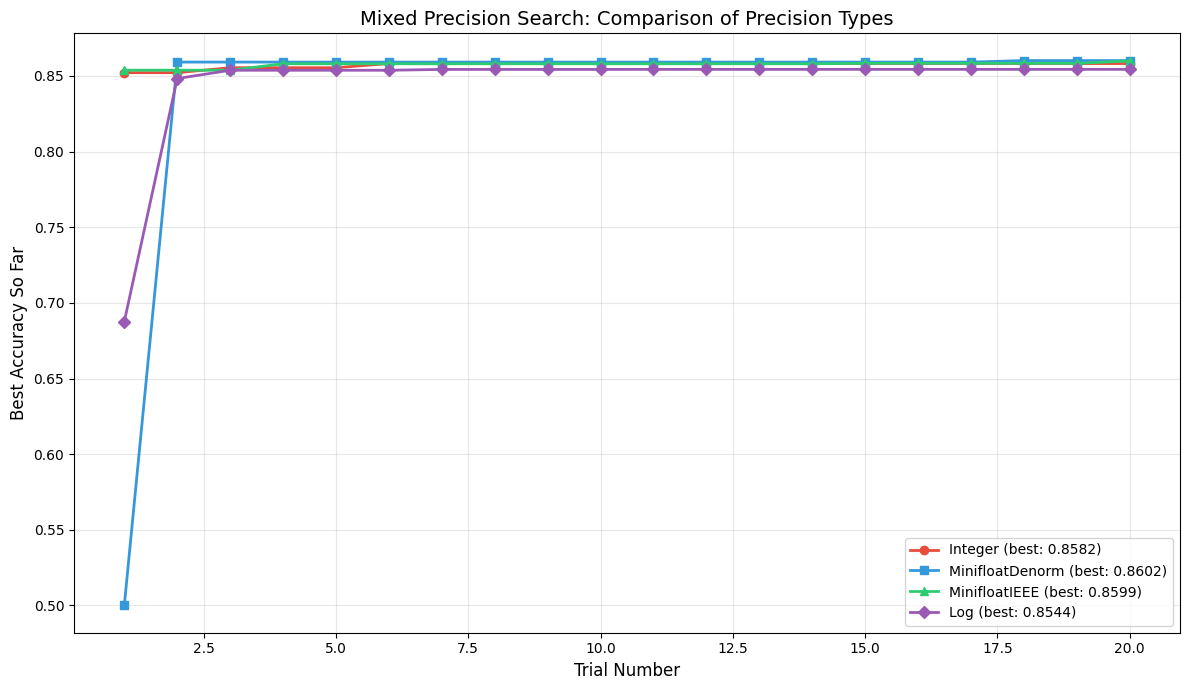


SUMMARY: Best Accuracy Per Precision Type
  MinifloatDenorm     : 0.8602
  MinifloatIEEE       : 0.8599
  Integer             : 0.8582
  Log                 : 0.8544


In [9]:
# ============ FIX: Create output directory and save results ============
import os

OUTPUT_DIR = Path("task2_results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Save results
with open(OUTPUT_DIR / "all_precision_results.json", "w") as f:
    json.dump(all_results, f, indent=2)

# ============ PLOT: ONE CURVE PER PRECISION ============
plt.figure(figsize=(12, 7))

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12']
markers = ['o', 's', '^', 'D', 'v']

for i, (precision_name, results) in enumerate(all_results.items()):
    best_so_far = results["best_so_far"]
    plt.plot(
        range(1, len(best_so_far) + 1), 
        best_so_far, 
        marker=markers[i % len(markers)],
        color=colors[i % len(colors)],
        linewidth=2, 
        markersize=6,
        label=f"{precision_name} (best: {results['best_accuracy']:.4f})"
    )

plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("Best Accuracy So Far", fontsize=12)
plt.title("Mixed Precision Search: Comparison of Precision Types", fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "precision_comparison.png", dpi=150)
plt.show()

# ============ SUMMARY TABLE ============
print("\n" + "="*60)
print("SUMMARY: Best Accuracy Per Precision Type")
print("="*60)
for precision_name, results in sorted(all_results.items(), key=lambda x: -x[1]["best_accuracy"]):
    print(f"  {precision_name:20s}: {results['best_accuracy']:.4f}")
print("="*60)